# RO change over time

## Imports

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import src.XRO

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Look at parameter change over time

Next, define a function to compute parameter changes over time

In [3]:
def get_ensemble_fits_over_time(
    data, model, ac_mask_idx, T_var="T_34", h_var="h", window_size=480, step_size=60
):
    """Get RO fits for each ensemble member as a function of time.
    Args:
        window_size: size of sliding window (units: months)
        step_size: how many months to slide the window between each calculation
    """

    ## Get number of timesteps in data
    n = len(data.time)

    ## empty list to hold results and dates
    fits_by_year = []
    start_dates = []

    ## loop through rolling windows
    for j, i in enumerate(tqdm.tqdm(np.arange(0, n - step_size, step_size))):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = data.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## get parameter fit
            _, fits = src.utils.get_RO_ensemble(
                data_subset,
                T_var=T_var,
                h_var=h_var,
                model=model,
                ac_mask_idx=ac_mask_idx,
            )

            ## drop X,Y,time variables
            fits = fits.drop_vars(["X", "Y", "Yfit", "time"])
            fits_by_year.append(fits)

    ## convert from list to xarray
    start_dates = xr.concat(start_dates, dim="time")
    fits_by_year = xr.concat(fits_by_year, dim=start_dates)

    return fits_by_year

### Do the computation and save parameters to file

In [4]:
## specify save filepath
fits_save_fp = pathlib.Path(SAVE_FP / "fits_apr-30-2025.nc")

## specify args for model fit
kwargs = dict(
    T_var="T_34",
    h_var="h",
    model=src.XRO.XRO(ncycle=12, ac_order=3, is_forward=True),
    ac_mask_idx=[(1, 1)],
    window_size=480,
    step_size=60,
)


## Get fits for each period
if fits_save_fp.is_file():

    ## Load parameters if already computed
    fits = xr.open_dataset(fits_save_fp)

else:

    ## compute fits
    fits = get_ensemble_fits_over_time(Th, **kwargs)

    ## save to file
    fits.to_netcdf(fits_save_fp)

## get parameters from fits
params = kwargs["model"].get_RO_parameters(fits)

## get normalized noise stats
fix_coords = lambda x: x.assign_coords({"cycle": params.cycle})
params["xi_T_norm"] = fix_coords(fits["normxi_stdac"].isel(ranky=0))
params["xi_h_norm"] = fix_coords(fits["normxi_stdac"].isel(ranky=1))

## get change from initial period
delta_params = params - params.sel(time=slice("1850", "1880")).mean("time")

### Plot diagnostics

#### Ensemble-mean growth rate as a function of seasonal cycle and time

In [5]:
Th[["T_34", "h"]].isel(time=slice(-480, None)).groupby("time.month").std(["time"]).mean(
    "member"
).to_dataarray()

<xarray.DataArray (variable: 2, month: 12)> Size: 192B
array([[1.02407684, 0.96718091, 0.91853436, 0.88568232, 0.8976968 ,
        0.88225723, 0.99356766, 1.074192  , 0.98767687, 0.9387785 ,
        0.96921373, 1.05295093],
       [2.31378948, 2.16012352, 2.16685404, 2.19036274, 2.22862963,
        2.20275521, 2.35460114, 2.57463562, 2.6506615 , 2.9592164 ,
        3.12207729, 2.73561294]])
Coordinates:
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * variable  (variable) object 16B 'T_34' 'h'
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

In [6]:
Th[["T_34", "h"]].groupby("time.month").std(["time", "member"]).to_dataarray()

<xarray.DataArray (variable: 2, month: 12)> Size: 192B
array([[1.00865898, 0.92304563, 0.86256035, 0.85486611, 0.87302642,
        0.83007436, 0.8548127 , 0.90247056, 0.87283439, 0.88486477,
        0.9551432 , 1.03722475],
       [2.12052466, 1.99438705, 1.97439515, 2.00925111, 2.06784865,
        2.09067144, 2.17514041, 2.33041784, 2.44914101, 2.6859546 ,
        2.75556208, 2.44457988]])
Coordinates:
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * variable  (variable) object 16B 'T_34' 'h'
Attributes:
    original_attribute_comment:        Temperature of the lower boundary of t...
    original_attribute_long_name:      Surface Temperature
    original_attribute_standard_name:  surface_temperature
    original_attribute_units:          K
    original_attribute_variable_name:  ts
    EnsoMetrics_operation:             1) TS (Surface Temperature (skin for o...
    EnsoMetrics_variable_calculation:  ts - 273.15
    EnsoMetrics_standard_name:         sea_surface_temperature
    EnsoMetrics_long_name:             Sea Surface Temperature
    EnsoMetrics_units:                 degC
    EnsoMetrics_variable_name:         sst

In [7]:
fits["Y_stdac"].isel(time=4).mean("member")

<xarray.DataArray 'Y_stdac' (ranky: 2, cycle: 12)> Size: 192B
array([[ 2.58603783,  2.79349411,  3.02598261,  3.28149968,  3.92359715,
         3.80224647,  3.187749  ,  2.61969899,  2.40953559,  2.49287502,
         2.40328468,  2.24511252],
       [11.87950339,  9.42482886,  8.43217443,  7.89263637,  7.90390854,
         8.07231521,  8.11032724,  7.81420279,  7.80795872,  8.64878818,
        11.21800698, 12.45837339]])
Coordinates:
  * cycle    (cycle) float64 96B 0.04167 0.125 0.2083 ... 0.7917 0.875 0.9583
  * ranky    (ranky) int32 8B 1 2
    time     datetime64[ns] 8B 1870-01-16T12:00:00

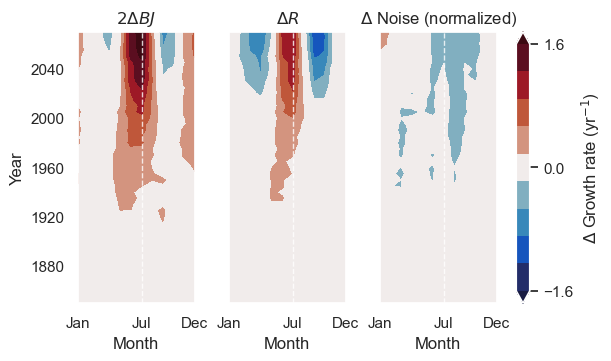

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(6, 3.5), layout="constrained")

## specify levels
# levels = np.arange(-1.6, 0.2, 0.2)
levels = src.utils.make_cb_range(1.5, 0.3)

## plot data
kwargs = dict(cmap="cmo.balance", levels=levels, extend="both")
cp0 = axs[0].contourf(
    params.cycle, params.time, 2 * delta_params["BJ_ac"].mean("member"), **kwargs
)

cp1 = axs[1].contourf(
    params.cycle, params.time, delta_params["R"].mean("member"), **kwargs
)

cp2 = axs[2].contourf(
    params.cycle, params.time, delta_params["xi_T_norm"].mean("member"), **kwargs
)

## set ticks and add guideline
for ax in axs:
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)
    ax.set_xlabel("Month")

## add colorbar
cb = fig.colorbar(cp2, label=r"$\Delta$ Growth rate (yr$^{-1}$)", ticks=[-1.6, 0, 1.6])

## label
axs[0].set_ylabel("Year")
axs[0].set_title(r"$2\Delta BJ$")
axs[1].set_title(r"$\Delta R$")
axs[2].set_title(r"$\Delta$ Noise (normalized)")
for ax in axs[1:]:
    ax.set_yticks([])

plt.show()

#### Plot ensemble stats

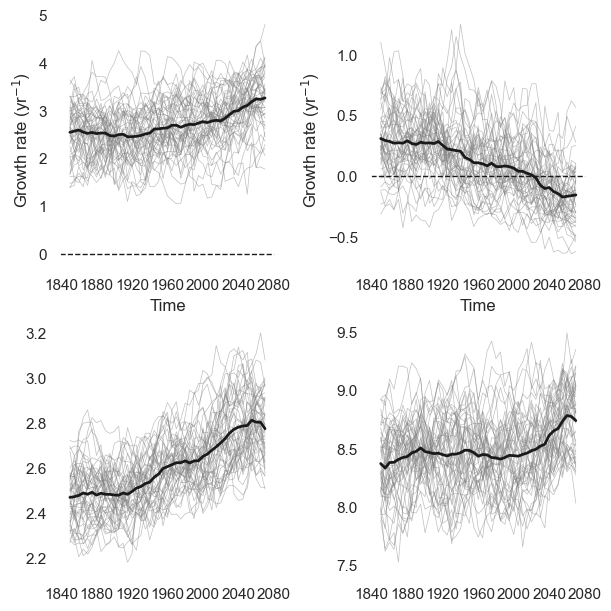

In [30]:
## param to plot
p = "epsilon"

fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout="constrained")

for p, ax in zip(["F2", "epsilon", "xi_T", "xi_h"], axs.flatten()):

    ## plot ensemble members
    for i, m in enumerate(params.member.values):

        label = "Ensemble members" if (i == 50) else None

        ax.plot(
            params.time,
            params[p].sel(member=m).mean("cycle"),
            c="gray",
            alpha=0.5,
            lw=0.5,
        )

    ## plot ensemble mean
    ax.plot(
        params.time,
        params[p].mean(["member", "cycle"]),
        c="k",
        lw=2,
        label="Ensemble mean",
    )

for ax in axs[0, :]:
    ## add labels and set plot style
    ax.axhline(0, c="k", ls="--", lw=1)
    ax.set_ylim([None, None])
    ax.set_xlabel("Time")
    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
    # ax.set_title("Max annual growth rate")
    # ax.legend()

plt.show()